# Customer Segmentation

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('online_retail.csv')
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


# Data Cleaning and Feature Engineering

In [3]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

The data has many missing customer IDs and most of these records are related to purchases with the same invoice date. A prudent measure to treat this missing data would be to create pseudo_IDs for the missing data however it will not be realistic as there are multiple purchases made by a customer. We will have to resort to eliminating theses rows from the data set

In [4]:
data = data.dropna()
data.isna().sum()
data = data.drop_duplicates()

In [5]:
from datetime import datetime

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

#Total purchases by customer
data = data.groupby('CustomerID').agg(
                            {'Quantity': 'sum',
                            'UnitPrice': 'mean',
                            'InvoiceNo': 'count',
                            'InvoiceDate': 'max'
                            })

data['TotalSpend'] = data['Quantity'] * data['UnitPrice']

latest_date = data['InvoiceDate'].max()

data['Recency'] = (latest_date  - data['InvoiceDate']).dt.days

customer_data = data.rename(columns={'InvoiceNo': 'Frequency'})


### Scaling the features

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_data = scaler.fit_transform(customer_data[['Quantity','Frequency','TotalSpend','Recency']])

# K-Means Clustering

### Randomly choose a K = 5 to test the clustering

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42) #Randomly choosing a number of Clusters.
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)

customer_data.groupby('Cluster').mean()

,Quantity,UnitPrice,Frequency,InvoiceDate,TotalSpend,Recency
Cluster,,,,,,
0,1123.563843,4.086280,102.840086,2011-10-30 18:12:05.046040576,3.771010e+03,39.254758
1,259.547858,19.371957,27.337284,2011-04-06 20:48:08.258887936,1.310010e+03,246.147675
2,34967.000000,4.794979,5824.250000,2011-12-08 02:24:30.000000000,1.684385e+05,1.000000
3,21475.500000,135.421382,146.000000,2011-10-26 23:57:00.000000000,2.347142e+06,43.000000
4,69521.545455,4.140229,1179.363636,2011-12-04 09:53:00.000000000,2.823442e+05,4.727273


#### Finding the optimal K using the elbow method by calculating the Within-Cluster Sum of Squares (WCSS)

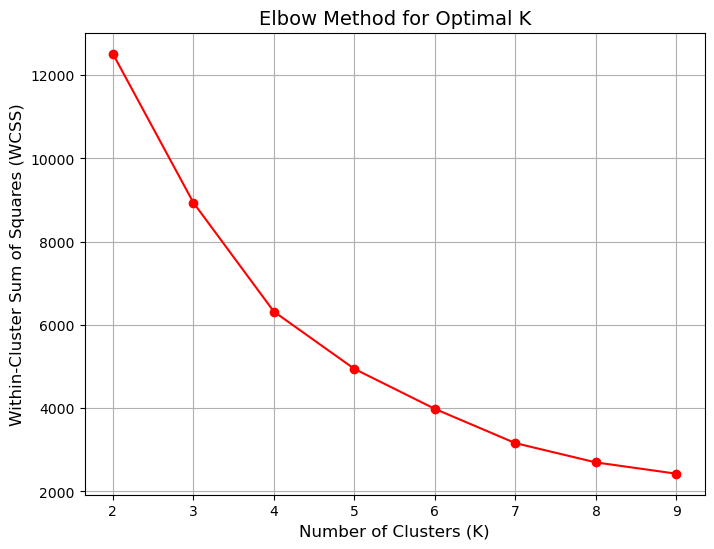

In [8]:
import matplotlib.pyplot as plt

wcss = []
K_range = range(2, 10)  

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)  
    wcss.append(kmeans.inertia_)  # Inertia = WCSS metric in K-Means



plt.figure(figsize=(8, 6))
plt.plot(K_range, wcss, marker='o', linestyle='-', color='r')


plt.title('Elbow Method for Optimal K', fontsize=14)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.grid(True)
plt.savefig('Elbow_Optimal_K.png', dpi=300, bbox_inches='tight')
plt.show()



The elbow appears to be at K = 4. Up until K=4, the WCSS decreases significantly, but after that, the reduction in WCSS becomes more gradual. The optimal K for customer data is 4.

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42) #Randomly choosing a number of Clusters.
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)

kmeans_clusters = customer_data.groupby('Cluster').mean()

kmeans_clusters

,Quantity,UnitPrice,Frequency,InvoiceDate,TotalSpend,Recency
Cluster,,,,,,
0,1123.563843,4.086280,102.840086,2011-10-30 18:12:05.046040576,3.771010e+03,39.254758
1,60307.000000,4.314829,2418.000000,2011-12-05 09:29:24.000000256,2.519693e+05,3.733333
2,259.547858,19.371957,27.337284,2011-04-06 20:48:08.258887936,1.310010e+03,246.147675
3,21475.500000,135.421382,146.000000,2011-10-26 23:57:00.000000000,2.347142e+06,43.000000


The cluster centroids for the features show the average behavior of customers in each cluster. Cluster 1 shows customers who have purchased in large quantities (21,475) and at high unit prices (135.42), indicating that they may be high-value customers.
Cluster 2, on the other hand, has much lower quantities and unit prices, suggesting these customers may be more occasional or lower-value buyers. Cluster 0 may represent small-scale buyers, and Cliuster 3 may represent large-scale buyers.

# Model Selection

Using the 4-means Clustering as a benchmark to compare to other algorithms like Agglomerative Clustering, and DBSCAN.

### Bootstrapping to evaluate the Variance Ratio of the three algorithms

In [10]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.utils import resample
from joblib import Parallel, delayed
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category=ConvergenceWarning)

def process_bootstrap(i, scaled_data):
    np.random.seed(i)
    X_bootstrap = resample(scaled_data, replace=True, n_samples=len(scaled_data))
    
    results = {
        'kmeans': {'score': 0, 'params': {}},
        'agglo': {'score': 0, 'params': {}},
        'dbscan': {'score': 0, 'params': {}}
    }
    
   
    k = 4  # optimal k from elbow method
    kmeans = KMeans(n_clusters=k, random_state=i, n_init=10)
    labels = kmeans.fit_predict(X_bootstrap)
    score = calinski_harabasz_score(X_bootstrap, labels)
    results['kmeans'] = {'score': score, 'params': {'n_clusters': k}}
    
    # Agglomerative Clustering
    for k in range(2, 10):
        agglo = AgglomerativeClustering(n_clusters=k)
        labels = agglo.fit_predict(X_bootstrap)
        score = calinski_harabasz_score(X_bootstrap, labels)
        if score > results['agglo']['score']:
            results['agglo'] = {'score': score, 'params': {'n_clusters': k}}
    
    # DBSCAN
    eps_range = np.linspace(0.1, 1.5, 10)
    min_samples_range = range(3, 10)
    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X_bootstrap)
            if len(set(labels)) > 1:
                score = calinski_harabasz_score(X_bootstrap, labels)
                if score > results['dbscan']['score']:
                    results['dbscan'] = {'score': score, 'params': {'eps': eps, 'min_samples': min_samples}}
    
    return results



##### Executing the models and determining the best parameters and scores

In [11]:
# Main execution
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

n_bootstraps = 100  
results = Parallel(n_jobs=-1)(delayed(process_bootstrap)(i, scaled_data) for i in range(n_bootstraps))

best_params = {
    'kmeans': {'score': 0, 'params': {}},
    'agglo': {'score': 0, 'params': {}},
    'dbscan': {'score': 0, 'params': {}}
}

for r in results:
    for method in best_params:
        if r[method]['score'] > best_params[method]['score']:
            best_params[method] = r[method]

print("Best parameters:")
for method, params in best_params.items():
    print(f"{method}: {params}")

Best parameters:
kmeans: {'score': 4921.307322435948, 'params': {'n_clusters': 4}}
agglo: {'score': 7135.945038032339, 'params': {'n_clusters': 9}}
dbscan: {'score': 2240.9266291101453, 'params': {'eps': 1.5, 'min_samples': 6}}


### Best Algorithm benchmarking with K-means 

In [13]:
best_algorithm = max(best_params.items(), key=lambda x: x[1]['score'])


if best_algorithm[0] == 'kmeans':
    final_model = KMeans(n_clusters=best_params['kmeans']['params']['n_clusters'], random_state=42)
elif best_algorithm[0] == 'agglo':
    final_model = AgglomerativeClustering(n_clusters=best_params['agglo']['params']['n_clusters'])
else:  
    final_model = DBSCAN(eps=best_params['dbscan']['params']['eps'], 
                         min_samples=best_params['dbscan']['params']['min_samples'])


# Best model using CALINSKI_HARABASZ SCORE
print(f"Best algorithm: {best_algorithm[0]}")
print(f"Best parameters: {best_params[best_algorithm[0]]['params']}")


Best algorithm: agglo
Best parameters: {'n_clusters': 9}


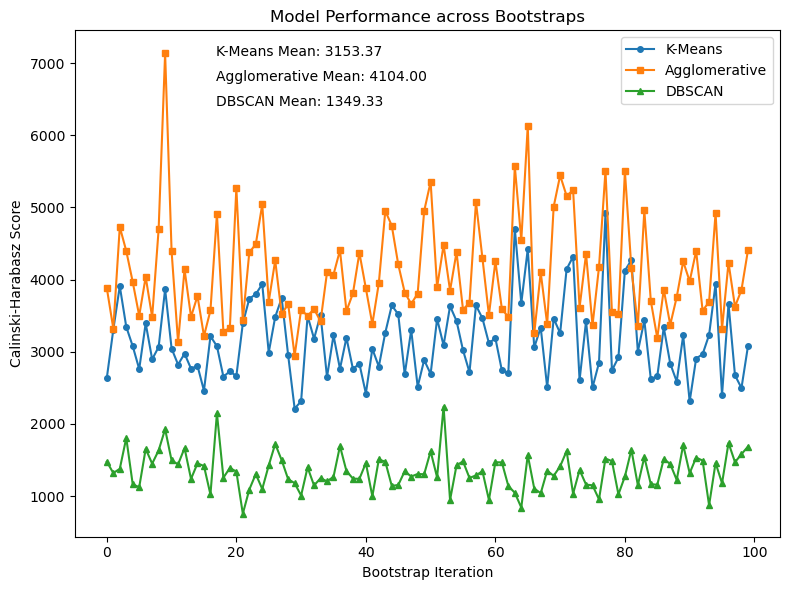


Best Kmeans parameters:
Score: 4921.31
Parameters: {'n_clusters': 4}

Best Agglo parameters:
Score: 7135.95
Parameters: {'n_clusters': 9}

Best Dbscan parameters:
Score: 2240.93
Parameters: {'eps': 1.5, 'min_samples': 6}


In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_clustering_performance(results):
    n_bootstraps = len(results)
    

    scores_kmeans = [r['kmeans']['score'] for r in results]
    scores_agglomerative = [r['agglo']['score'] for r in results]
    scores_dbscan = [r['dbscan']['score'] for r in results]


    plt.figure(figsize=(8, 6))

   
    plt.plot(range(n_bootstraps), scores_kmeans, label='K-Means', marker='o', linestyle='-', markersize=4)
    plt.plot(range(n_bootstraps), scores_agglomerative, label='Agglomerative', marker='s', linestyle='-', markersize=4)
    plt.plot(range(n_bootstraps), scores_dbscan, label='DBSCAN', marker='^', linestyle='-', markersize=4)

 
    plt.xlabel('Bootstrap Iteration')
    plt.ylabel('Calinski-Harabasz Score')
    plt.title('Model Performance across Bootstraps')
    plt.legend(loc='best')
    plt.grid(False)

   #Annotations
    mean_kmeans = np.mean(scores_kmeans)
    mean_agglomerative = np.mean(scores_agglomerative)
    mean_dbscan = np.mean(scores_dbscan)

    plt.annotate(f'K-Means Mean: {mean_kmeans:.2f}', xy=(0.20, 0.95), xycoords='axes fraction')
    plt.annotate(f'Agglomerative Mean: {mean_agglomerative:.2f}', xy=(0.20, 0.90), xycoords='axes fraction')
    plt.annotate(f'DBSCAN Mean: {mean_dbscan:.2f}', xy=(0.20, 0.85), xycoords='axes fraction')

    plt.tight_layout()
    plt.savefig('Model_Performance_Across_Bootstraps.png', dpi=300, bbox_inches='tight')
    plt.show()


plot_clustering_performance(results)


for algorithm in ['kmeans', 'agglo', 'dbscan']:
    best_score = max(r[algorithm]['score'] for r in results)
    best_params = next(r[algorithm]['params'] for r in results if r[algorithm]['score'] == best_score)
    print(f"\nBest {algorithm.capitalize()} parameters:")
    print(f"Score: {best_score:.2f}")
    print(f"Parameters: {best_params}")

While the Agglomerative algorithm achieved the highest Calinski-Harabasz score, its mean is fairly comparable to K-Means, which uses fewer clusters. Given that K-Means offers better interpretability and simplicity, it may be a preferable choice despite the slight trade-off in score. We proceed to use PCA for 

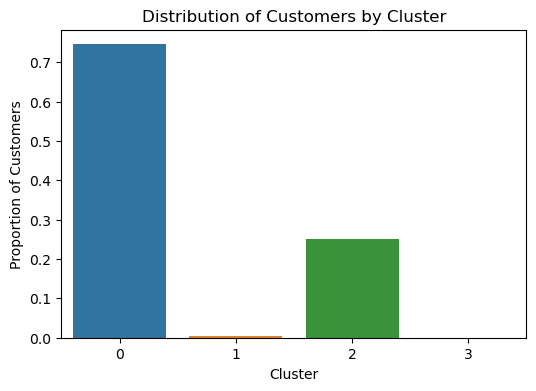

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt


cluster_distribution = customer_data['Cluster'].value_counts(normalize=True).reset_index()
cluster_distribution.columns = ['Cluster', 'Proportion']

plt.figure(figsize=(6, 4))
sns.barplot(x='Cluster', y='Proportion', data=cluster_distribution)

plt.xlabel('Cluster')
plt.ylabel('Proportion of Customers')
plt.title('Distribution of Customers by Cluster')

plt.show()


In [18]:
kmeans_clusters

,Quantity,UnitPrice,Frequency,InvoiceDate,TotalSpend,Recency
Cluster,,,,,,
0,1123.563843,4.086280,102.840086,2011-10-30 18:12:05.046040576,3.771010e+03,39.254758
1,60307.000000,4.314829,2418.000000,2011-12-05 09:29:24.000000256,2.519693e+05,3.733333
2,259.547858,19.371957,27.337284,2011-04-06 20:48:08.258887936,1.310010e+03,246.147675
3,21475.500000,135.421382,146.000000,2011-10-26 23:57:00.000000000,2.347142e+06,43.000000


# Cluster Labeling 

Based on the centroids of these clusters:

Cluster 0: Small Retailers: Customers in this cluster buy a moderate quantity of goods (1123 units on average) at a relatively low unit price (4.09). Their frequency of purchases is high, and they spend a significant amount overall $3,771. These customers are likely small businesses that make regular, bulk purchases but operate at a smaller scale.

Cluster 1: Large Wholesalers: This group has a significantly high total spend (~ $251,969) and makes massive bulk purchases (60,307 units on average), which suggests these are likely large wholesale distributors. They operate with relatively low recency (3.73 days), indicating frequent transactions, typical of large wholesale operations.

Cluster 2: Boutique Shops: This cluster has lower quantity purchases (259 units) but pays a higher unit price (19.37), possibly indicating specialty or  businesses purchasing premium products. They are less frequent buyers, with a higher recency, which suggests occasional but expensive purchases.

Cluster 3: Corporate Clients: These customers spend the most ($2.35 million) and buy very large quantities (21,475 units), often at a high price ($135.42). Their purchase frequency is not as high as Cluster 1, but their overall spending suggests they are corporate clients with large, infrequent orders.

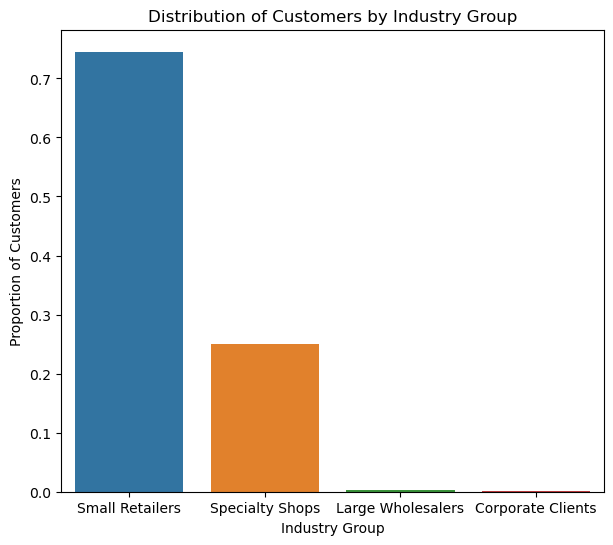

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cluster distribution
cluster_distribution = customer_data['Cluster'].value_counts(normalize=True).reset_index()
cluster_distribution.columns = ['Cluster', 'Proportion']

# Dictionary to map clusters to industry groups
industry_groups = {
    0: 'Small Retailers',
    1: 'Large Wholesalers',
    2: 'Specialty Shops',
    3: 'Corporate Clients'
}

# Replace the cluster numbers with industry group names
cluster_distribution['Cluster'] = cluster_distribution['Cluster'].map(industry_groups)

# Plotting
plt.figure(figsize=(7, 6))
sns.barplot(x='Cluster', y='Proportion', data=cluster_distribution)

plt.xlabel('Industry Group')
plt.ylabel('Proportion of Customers')
plt.title('Distribution of Customers by Industry Group')

plt.show()


# Visualizing the Clusters using PCA (2-Dimensional)

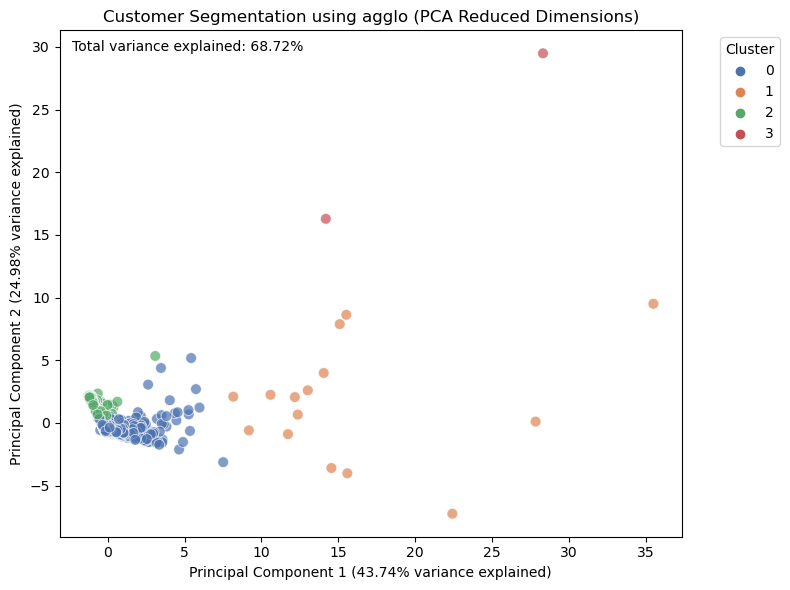


Top features contributing to principal components:

PC1 top contributors:
Feature 0    0.631127
Feature 1    0.558933
Feature 2    0.449000
Feature 3    0.296093
Name: PC1, dtype: float64

PC2 top contributors:
Feature 3    0.778183
Feature 2    0.555763
Feature 1    0.233356
Feature 0    0.176363
Name: PC2, dtype: float64


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

def plot_pca_clusters(scaled_data, cluster_labels, best_algorithm):
    # Reducing the dimensionality to 2D using PCA
    pca = PCA(n_components= 2)
    pca_data = pca.fit_transform(scaled_data)


    pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'])
    pca_df['Cluster'] = cluster_labels

    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='deep', s=60, alpha=0.7)

    plt.title(f'Customer Segmentation using {best_algorithm} (PCA Reduced Dimensions)')
    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)')
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)')


    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

  
    total_var = pca.explained_variance_ratio_.sum()
    plt.annotate(f'Total variance explained: {total_var:.2%}', 
                 xy=(0.02, 0.98), xycoords='axes fraction',
                 fontsize=10, ha='left', va='top')

    plt.tight_layout()
    plt.show()

    # Print top features contributing to each principal component
    print("\nTop features contributing to principal components:")
    feature_importance = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(2)],
        index=scaled_data.columns if hasattr(scaled_data, 'columns') else [f'Feature {i}' for i in range(scaled_data.shape[1])]
    ).abs()

    for i in range(2):
        print(f"\nPC{i+1} top contributors:")
        print(feature_importance[f'PC{i+1}'].nlargest(5))



plot_pca_clusters(scaled_data, cluster_labels, best_algorithm[0])

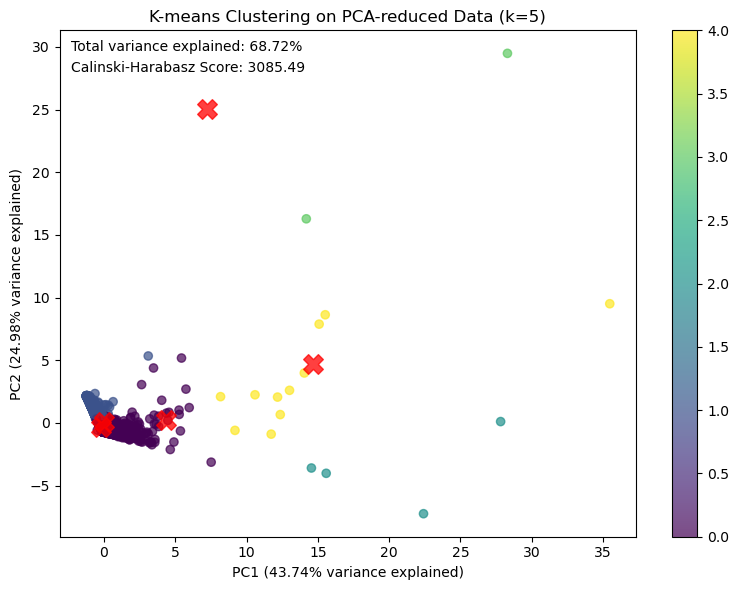


Top features contributing to principal components:

PC1 top contributors:
Feature 0    0.631127
Feature 1    0.558933
Feature 2    0.449000
Feature 3    0.296093
Name: PC1, dtype: float64

PC2 top contributors:
Feature 3    0.778183
Feature 2    0.555763
Feature 1    0.233356
Feature 0    0.176363
Name: PC2, dtype: float64

Calinski-Harabasz Score: 3085.49
Number of samples in each cluster:
0    3258
1    1097
2       4
3       2
4      11
Name: count, dtype: int64


In [36]:

def pca_kmeans_analysis(scaled_data, n_components=2, n_clusters=4, random_state=42):
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(scaled_data)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = kmeans.fit_predict(scaled_data)
    
    ch_score = calinski_harabasz_score(pca_data, cluster_labels)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    
    plt.title(f'K-means Clustering on PCA-reduced Data (k={n_clusters})')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)')
    
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
    

    total_var = pca.explained_variance_ratio_.sum()
    plt.annotate(f'Total variance explained: {total_var:.2%}', 
                 xy=(0.02, 0.98), xycoords='axes fraction',
                 fontsize=10, ha='left', va='top')
    plt.annotate(f'Calinski-Harabasz Score: {ch_score:.2f}', 
                 xy=(0.02, 0.94), xycoords='axes fraction',
                 fontsize=10, ha='left', va='top')
    
    plt.tight_layout()
    plt.show()
    
 
    print("\nTop features contributing to principal components:")
    feature_importance = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=scaled_data.columns if hasattr(scaled_data, 'columns') else [f'Feature {i}' for i in range(scaled_data.shape[1])]
    ).abs()

    for i in range(n_components):
        print(f"\nPC{i+1} top contributors:")
        print(feature_importance[f'PC{i+1}'].nlargest(5))
    
    return pca, kmeans, cluster_labels, ch_score


n_clusters = 5

pca, kmeans, cluster_labels, ch_score = pca_kmeans_analysis(scaled_data, n_components=2, n_clusters=n_clusters)

customer_data['Cluster'] = cluster_labels

print(f"\nCalinski-Harabasz Score: {ch_score:.2f}")
print(f"Number of samples in each cluster:\n{pd.Series(cluster_labels).value_counts().sort_index()}")

The Calinski-Harabasz score suggests good cluster quality, but the extremely small cluster sizes (Cluster 1 and Cluster 3) may indicate potential outliers or sparse customer groups. The PCA diagrams demonstrate that K-means clustering effectively groups the data similarly to Agglomerative Clustering, but with fewer clusters, contributing to improved model simplicity. 

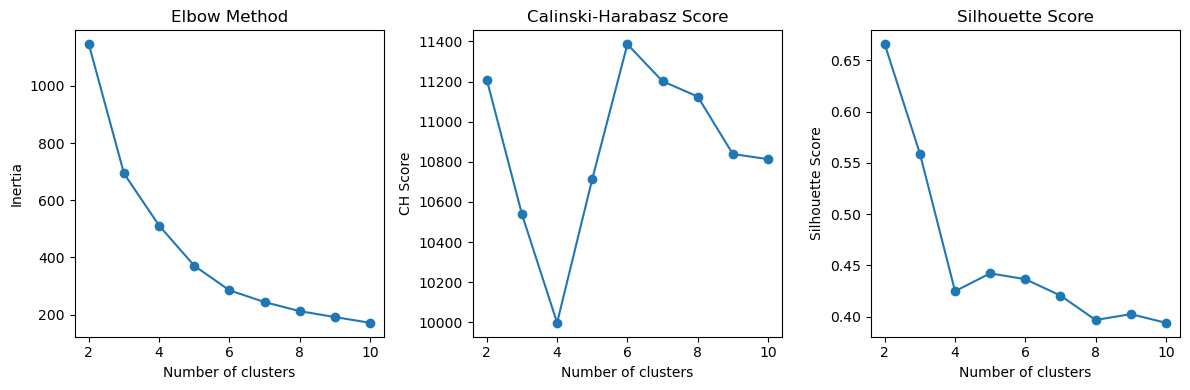

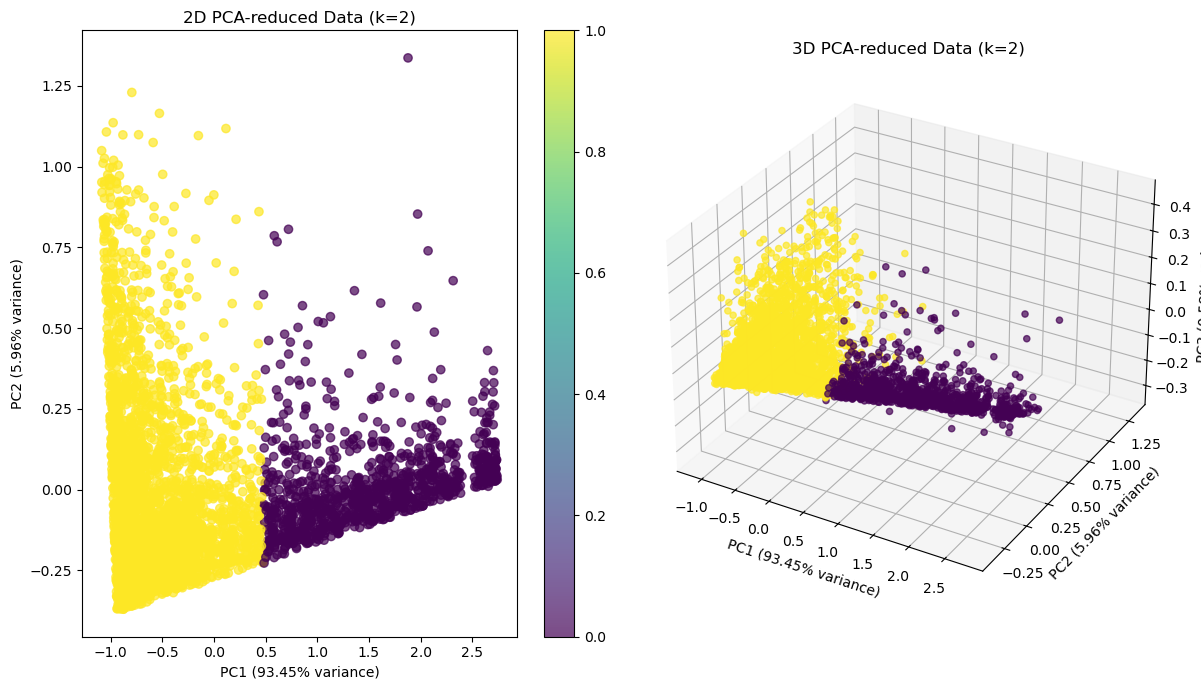


Top features contributing to principal components:

PC1 top contributors:
Feature 3    0.993776
Feature 1    0.101015
Feature 0    0.045803
Feature 2    0.010357
Name: PC1, dtype: float64

PC2 top contributors:
Feature 1    0.938345
Feature 0    0.318693
Feature 3    0.110853
Feature 2    0.075208
Name: PC2, dtype: float64

PC3 top contributors:
Feature 0    0.925190
Feature 1    0.330454
Feature 2    0.186286
Feature 3    0.010993
Name: PC3, dtype: float64

Number of samples in each cluster:
-1     438
 0    1053
 1    2881
Name: count, dtype: int64

Number of outliers: 438

Silhouette Score: 0.6658
Calinski-Harabasz Score: 11209.61


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.covariance import EllipticEnvelope

def improved_pca_kmeans_analysis(scaled_data, max_clusters=10, n_components=3, random_state=42, outlier_fraction=0.1):
    # Outlier detection
    outlier_detector = EllipticEnvelope(contamination=outlier_fraction, random_state=random_state)
    outlier_labels = outlier_detector.fit_predict(scaled_data)
    inlier_mask = outlier_labels == 1
    inlier_data = scaled_data[inlier_mask]

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(inlier_data)

    # Elbow method
    inertias = []
    ch_scores = []
    silhouette_scores = []
    
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        cluster_labels = kmeans.fit_predict(pca_data)
        inertias.append(kmeans.inertia_)
        ch_scores.append(calinski_harabasz_score(pca_data, cluster_labels))
        silhouette_scores.append(silhouette_score(pca_data, cluster_labels))

    # Plot elbow curve
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.plot(range(2, max_clusters + 1), inertias, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')

    plt.subplot(132)
    plt.plot(range(2, max_clusters + 1), ch_scores, marker='o')
    plt.title('Calinski-Harabasz Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('CH Score')

    plt.subplot(133)
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')

    plt.tight_layout()
    plt.show()

    # Select optimal number of clusters (you can adjust this based on the plots)
    optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

    # Perform final clustering
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=random_state)
    cluster_labels = kmeans.fit_predict(pca_data)

    # Visualize results
    fig = plt.figure(figsize=(12, 7))
    
    # 2D plot
    ax1 = fig.add_subplot(121)
    scatter = ax1.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
    ax1.set_title(f'2D PCA-reduced Data (k={optimal_clusters})')
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.colorbar(scatter)

    # 3D plot
    ax2 = fig.add_subplot(122, projection='3d')
    scatter = ax2.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=cluster_labels, cmap='viridis', alpha=0.7)
    ax2.set_title(f'3D PCA-reduced Data (k={optimal_clusters})')
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax2.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%} variance)')
    
    plt.tight_layout()
    plt.show()

    # Feature importance analysis
    feature_importance = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=scaled_data.columns if hasattr(scaled_data, 'columns') else [f'Feature {i}' for i in range(scaled_data.shape[1])]
    ).abs()

    print("\nTop features contributing to principal components:")
    for i in range(n_components):
        print(f"\nPC{i+1} top contributors:")
        print(feature_importance[f'PC{i+1}'].nlargest(5))

    # Create full_cluster_labels with the same length as the original data
    full_cluster_labels = np.full(len(scaled_data), -1)  # -1 for outliers
    full_cluster_labels[inlier_mask] = cluster_labels

    return pca, kmeans, full_cluster_labels, feature_importance, inlier_mask

# Usage
n_components = 3
pca, kmeans, cluster_labels, feature_importance, inlier_mask = improved_pca_kmeans_analysis(scaled_data, n_components=n_components)

# Add cluster labels to original data
customer_data['Cluster'] = cluster_labels

print(f"\nNumber of samples in each cluster:\n{pd.Series(cluster_labels).value_counts().sort_index()}")
print(f"\nNumber of outliers: {sum(cluster_labels == -1)}")
print(f"\nSilhouette Score: {silhouette_score(pca.transform(scaled_data[inlier_mask]), cluster_labels[inlier_mask]):.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(pca.transform(scaled_data[inlier_mask]), cluster_labels[inlier_mask]):.2f}")

# Assigning customers to Industry Groups

In [29]:
customer_data['Cluster'] = cluster_labels

industry_groups = {
    0: 'Small Retailers',
    1: 'Large Wholesalers',
    2: 'Specialty Shops',
    3: 'Corporate Clients'
}

customer_data['Cluster Description'] = customer_data['Cluster'].map(industry_groups)


output_data = customer_data[['Cluster', 'Cluster Description']]

output_data.to_csv('customer_industry_grouping.csv', index=False)

print("CSV file created with customer IDs and their assigned clusters.")




CSV file created with customer IDs and their assigned clusters.


In [30]:
output_data.head()

,Cluster,Cluster Description
CustomerID,,
12346.0,2,Specialty Shops
12347.0,0,Small Retailers
12348.0,0,Small Retailers
12349.0,0,Small Retailers
12350.0,2,Specialty Shops


# Pipeline

In [31]:
from sklearn.pipeline import Pipeline
import joblib  

pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('kmeans', KMeans(n_clusters=4, random_state=42))
])

pipeline.fit(scaled_data)

joblib.dump(pipeline, 'kmeans_clustering_pipeline.pkl')


['kmeans_clustering_pipeline.pkl']